# Study false detections around bright star masks
The radius of current HSC bright star masks, made by Andy Goulding, are selected by comparing the density of detections in increasingly large annuli around each bright stars with the average detection density. 

Still, false detections are present right outside the edge of masks for several objects. The aim of this notebook is to provide a plot of the number of detections as a function of radius around bright stars to visualize this problem.

## Options
Change cell below to choose the filter (note it only changes masks read in for now, since we read detections from merged catalog), tracts, and binning options for the annuli:

In [1]:
chosenFilter = "HSC-R" 
#tractList = [9813] 
tractList = [9615, 9697, 9813] #RC2

# parameters for plot below
#annSize = 10
annSize = 2.5 # size of each consecutive annulus, in arcsec
#radMax = 600 
radMax = 150 # outer radius for the largest annulus

# print a few checkpoints etc
verbose = False

Change this cell for plot parameters: how to perform the magnitude binning (for bright objects), whether to have a common y-axis and whether plots should be saved or only displayed in the notebook:

In [2]:
# magnitude bins and corresponding labels
mag_bins = [0, 12, 14] + list(range(15,19))
mag_labs = ['mag < 12', '12 < mag < 14'] + [
            '{} < mag < {}'.format(mfrom,mto)
            for mfrom,mto in zip(mag_bins[2:],mag_bins[3:])]

# fix y-axis span to 0-to-2.5 times average detection density (as in Coupon et al., 2014, Fig. 8)
fixYAxis = True

# whether to save plots and what to call them
savePlots = True
plotStub = "smallBins"
plotExt = ".png"

The rest of the notebook should not require any changes before being ran (though note the cell that actually computes the number counts takes a few minutes per tract, depending on annuli parameters).

## Set up
Starting with usual imports:

In [3]:
%matplotlib inline
import numpy as np
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst import geom
import matplotlib.pyplot as plt
import time
import os

Initialize Butler repo:

In [4]:
butler = Butler("/datasets/hsc/repo/rerun/RC/w_2020_03/DM-23121_obj/")

Define annuli borders and area:

In [5]:
annRadii = np.arange(0, radMax, annSize)
annAreas = np.array([np.pi *(radOut**2 - radIn**2) for
                     radIn,radOut in zip(annRadii,annRadii[1:])])

If plots are to be saved, make sure the folder exists:

In [6]:
if savePlots:
    if not os.path.isdir('plots/'):
        os.makedirs('plots/')

Path to Andy Goulding's masks:

In [7]:
if chosenFilter=='HSC-G':
    filter_lc = 'g'
elif chosenFilter=='HSC-R':
    filter_lc = 'r'
elif chosenFilter=='HSC-I':
    filter_lc = 'i'
elif chosenFilter=='HSC-z':
    filter_lc = 'z'
elif chosenFilter=='HSC-y':
    filter_lc = 'y'
print(filter_lc)
mask_path = "/datasets/hsc/BrightObjectMasks/GouldingMasksS18A/new_S18Amask_{}.reg".format(filter_lc)

r


Extract mask information from the ds9 region files. Note this is pretty hacky but is only used for these specific masks - ultimately, it would be better to select the bright objects we look at from an external catalog (Gaia).

In [8]:
def extractBrightStarInfo(tractInfo, chosenFilter, mask_path, radMaxPix, verbose=False):
    f = open(mask_path, 'r')

    # boundaries; shrink BBox so largest annuli can fit in entirely
    bBox = tractInfo.getBBox()
    bBox.grow(-int(radMaxPix)-1)
    wcs = tractInfo.getWcs()

    pix_centers = []
    mags = []
    radii = []
    
    for line in f:
        if line[:6] == 'circle':
            maskinfo, comm = line.split('#')
            objid, mag = comm.split(',')
            maskinfo = maskinfo.split(',')
            radius = maskinfo[2].split('d')[0] # keep everything before the d
            circle = [float(maskinfo[0][7:]), # remove "circle("
                        float(maskinfo[1])]
            sp = geom.SpherePoint(circle[0], circle[1], geom.degrees)
            cpix = wcs.skyToPixel(sp)
            if (cpix[0] >= bBox.beginX and 
                cpix[0] < bBox.endX):
                if (cpix[1] >= bBox.beginY and 
                    cpix[1] < bBox.endY):
                    # also save magnitude (as put down by Andy)...
                    mag = float(mag[5:-2]) # remove " mag:" and the trailing \n
                    mags += [mag]
                    # ... and mask radius
                    radii += [float(radius)]
                    # if the center of the mask is inside, keep it
                    pix_centers += [cpix]
        elif line[:3] == 'box': # ignore saturation/bleed trails boxes
            pass
        else: 
            if verbose:
                # check we didn't miss anything important
                print(line)
    f.close()
    mags = np.array(mags)
    radii = np.array(radii) * 3600 # arcsec
    return pix_centers, mags, radii

And function to compute (detected) source densities around a set of objects:

In [9]:
def sourceCountAround(df, tractInfo, chosenFilter, radiiPix, radMaxPix, verbose=False):
    """Compute detected source counts around all bright stars in the chosen tract.
    `df` should be a dataframe containing an `'x'` and a `'y'` column with pixel centroids
    for each detection.
    `tractInfo` the eponymous object for this tract from the sky map"""
    # extract bright star mask info for this tract
    brightCenters, brightMags, brightRadii = extractBrightStarInfo(tractInfo, chosenFilter, mask_path,
                                                                    radMaxPix, verbose)
    
    allCounts = []
    for j,brightCen in enumerate(brightCenters):
        start = time.time()
        counts = []
        # only consider detections within a square of width 2 outer radii
        withinSquare = ((df['x'] >= brightCen[0]-radMaxPix) &
                      (df['x'] < brightCen[0]+radMaxPix) &
                      (df['y'] >= brightCen[1]-radMaxPix) &
                      (df['y'] < brightCen[1]+radMaxPix)) 
        candidates = df[withinSquare]
        # compute distance to bright object for all candidates
        dist = np.sqrt((candidates['x'] - brightCen[0])**2 + 
                       (candidates['y'] - brightCen[1])**2)
        for radIn,radOut in zip(radiiPix,radiiPix[1:]):
            # count those within annulus
            inAnnulus = (dist >= radIn) & (dist < radOut)
            counts += [np.sum(inAnnulus)]
        end = time.time()
        if not j%500 and verbose:
            print('Bright object {} out of {}; time elapsed for this object: {}s'.format(
                j+1,len(brightCenters),end-start))
        allCounts += [counts]
    allCounts = np.array(allCounts)
    return allCounts, brightMags, brightRadii

## Run
Warning: running cell below takes a while.

In [10]:
densities, brightMags, brightRads = [], [], []
for tract in tractList:
    # load source catalog
    tract_src = butler.get('objectTable_tract', tract=tract)
    df = tract_src.toDataFrame(columns = ['x', 'y'])
    
    # get sky map and WCS for this tract
    skymap = butler.get("deepCoadd_skyMap", tract=tract, filter=chosenFilter)
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    
    # convert annuli parameters to pixel
    pixScale = geom.radToArcsec(wcs.getPixelScale())
    annSizePix = annSize / pixScale
    radMaxPix = radMax / pixScale
    radiiPix = annRadii / pixScale
    
    counts, mags, rads = sourceCountAround(df, tractInfo, chosenFilter, radiiPix, radMaxPix,
                                          verbose=verbose)
    
    # normalize by annulus area
    dens = counts / annAreas.reshape(1,-1)
    #den, mags, rads = sourceDensityAround(df, tract, chosenFilter, annSize, radMax,
    #                                      verbose=verbose)
    densities += [dens]
    brightMags += [mags]
    brightRads += [rads]

## Plots!


Compute a very crude "average density" by just averaging those measured here beyond 500arcsec:

In [11]:
avgDens = [0.05245036859438729, 0.04699019430559107, 0.06393179281292363]
computed = """[]
for dens in densities:
    above500 = annRadii[:-1]>500
    avgDens += [np.mean(dens[:,above500])]"""

Plot a few individual objects first just to check:

In [12]:
if verbose:
    for dens, mags, rads, avgDen in zip(densities, brightMags, brightRads, avgDens):
        for starIdx in np.argsort(mags)[:100]:
            brst = dens[starIdx]
            plt.plot(annRadii[:-1], brst)
            plt.axvline(rads[starIdx], ls='--', c='k')
            plt.axhline(avgDen, ls=':', c='k', alpha=.7)
            plt.xlabel('(Inner) radius from bright obj (arcsec)')
            plt.ylabel(r'Detection density (arcsec$^{-2}$)')
            plt.title('mag:{}'.format(mags[starIdx]))
            plt.show()
            plt.close()

Then average per magnitude bin:

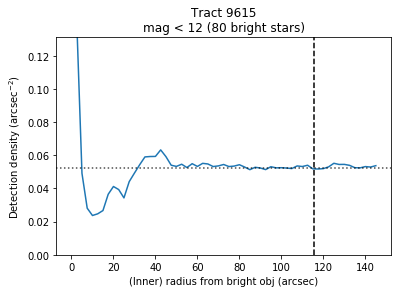

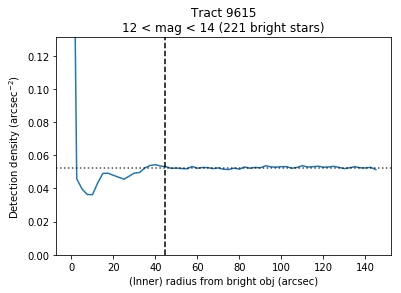

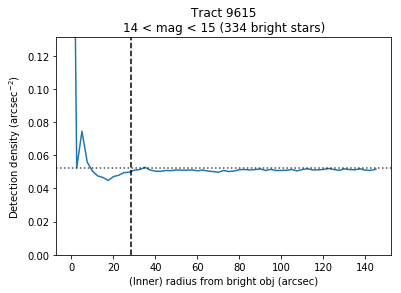

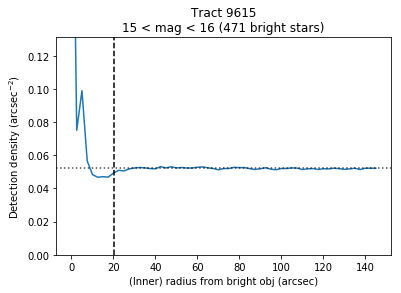

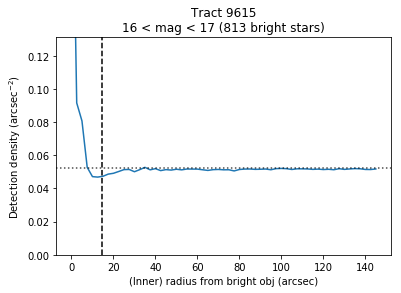

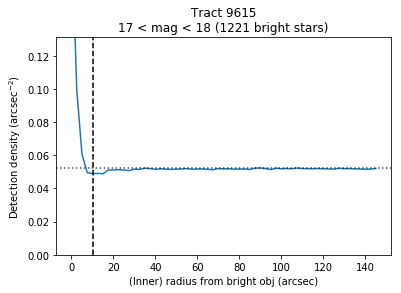

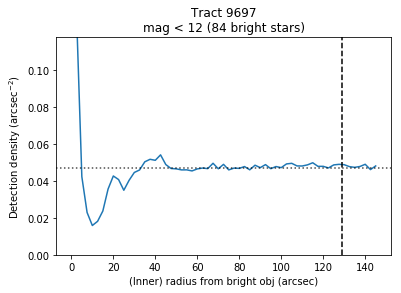

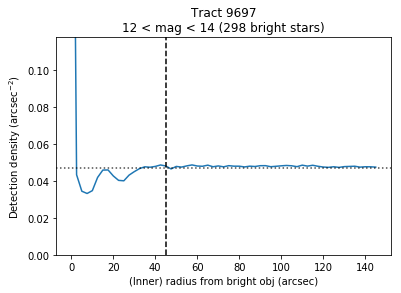

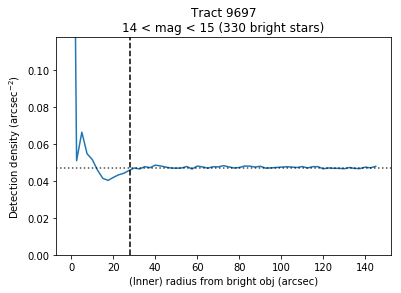

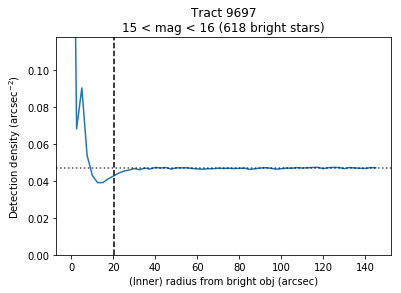

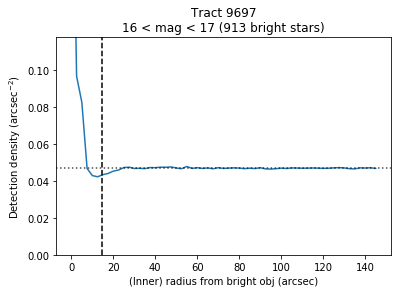

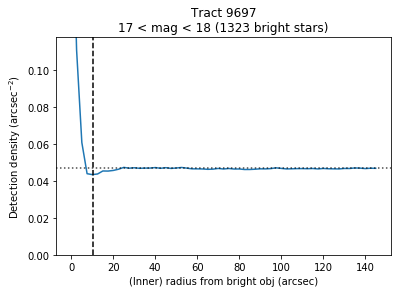

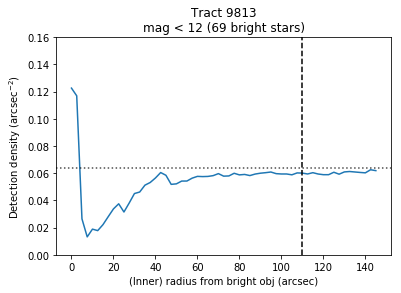

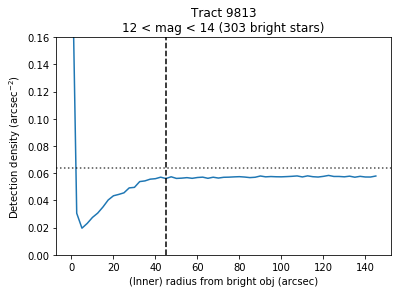

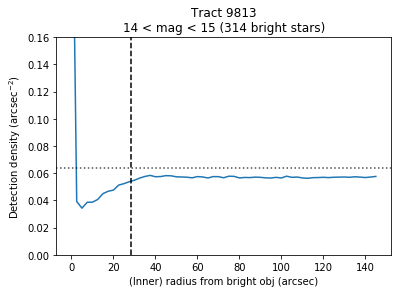

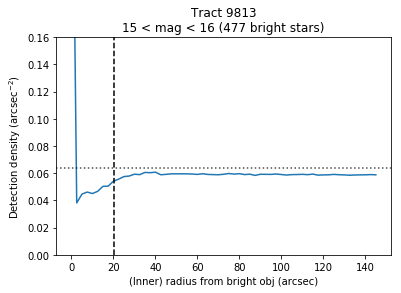

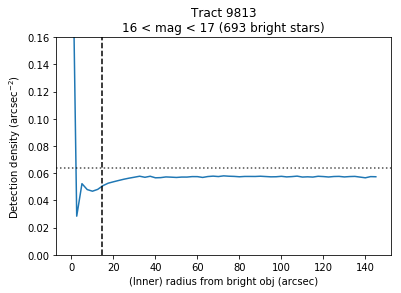

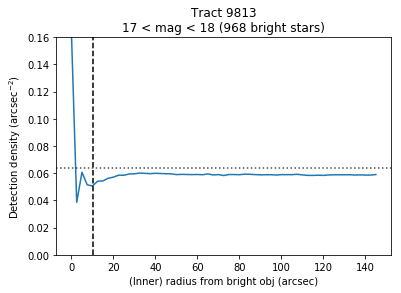

In [13]:
for tract, dens, mags, rads, avgDen in zip(tractList, densities, brightMags, brightRads, avgDens):
    for mlab,(mfrom,mto) in zip(mag_labs,zip(mag_bins,mag_bins[1:])):
        binidx = (mags >= mfrom) * (mags < mto)
        # average detection densities around stars in this magnitude bin:
        magDen = np.mean(dens[binidx],axis=0)
        # average Andy mask radii:
        magRad = np.mean(rads[binidx])

        plt.plot(annRadii[:-1], magDen)
        plt.axvline(magRad, ls='--', c='k')
        plt.axhline(avgDen, ls=':', c='k', alpha=.7)

        plt.title("Tract {}\n".format(tract) +
                  mlab + " ({} bright stars)".format(np.sum(binidx)))
        
        plt.xlabel('(Inner) radius from bright obj (arcsec)')
        plt.ylabel(r'Detection density (arcsec$^{-2}$)')
        if fixYAxis:
            try:
                plt.ylim(0, 2.5*avgDen)
            except ValueError:
                raise ValueError("Could not set y axis limits; likely because you could not compute\
     average source density")
        
        if savePlots:
            plt.savefig('plots/' + plotStub + '_{}_tract{}_mag{}{}'.format(
                        chosenFilter, tract, mfrom, plotExt))
            
        plt.show()
        plt.close()